# GCM Filters on Irregular Grids

This notebook explains how to use two different filter types with Gcm-filters on irregular grids:
* Filters with **fixed filter length scale**, e.g., a filter that attempts to remove scales smaller than 100km.
* Filters with **fixed coarsening factor**, e.g., a filter that attempts to remove scales smaller than 4 times the local grid scale.

In this example, we are going to use NeverWorld2 data. NeverWorld2 is a **MOM6** simulation in stacked shallow water mode, on a non-global lat-lon grid. The data is stored on NCAR's Casper cluster.

In [53]:
import gcm_filters
import numpy as np
import cupy as cp
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
#import cartopy
import cartopy.crs as ccrs

In [2]:
print(xr.__version__)
print(cp.__version__)

0.16.2
8.2.0


First, we open the 1/8 degree NeverWorld2 data.

In [3]:
run = 26 #1/8 deg
end_time = 31500

st = xr.open_dataset('/glade/u/home/bachman/Jupyter_Notebooks/filter_Scotia_Sea_MITgcm/aniso_filter_MITgcm.nc', decode_times=False) 

#chunks = {'time': 20} 
#av = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/averages_000%i.nc' % (run,end_time-500+2), 
#                     chunks=chunks, decode_times=False)

These are our horizontal dimensions:

In [4]:
Nx = np.size(st.lon)
Ny = np.size(st.lat)
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 6912, Ny = 1536


## Filter with fixed filter length scale

The following are the grid types that we have so far implemented in GCM-filters:

In [5]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>]

To filter with fixed filter length scale, we will use the grid type: `IRREGULAR_CARTESIAN_WITH_LAND`, and its associated Laplacian. The Laplacian needs the following grid variables:

In [6]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In our example, we will filter **tracer fields**, i.e., fields that are defined at T-points (e.g., `h`, `KE`). 

(`IRREGULAR_CARTESIAN_WITH_LAND` could also be used to filter U-fields or V-fields, but we would have to create the filter with different arguments for `wet_mask`, `dxw`, `dyw`, `dxs`, `dys`, `area`.)

`wet_mask` and `area` we have directly available from our model output:

In [7]:
wet_mask = st.wet_mask
area = st.area

For the remaining grid variables, recall the following conventions:

* `dxw` = x-spacing centered at western cell edge
* `dyw` = y-spacing centered at western cell edge
* `dxs` = x-spacing centered at southern cell edge
* `dys` = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [8]:
dxw = xr.DataArray(data=st.dx.isel(lon=slice(0,Nx)),coords={'lat':st.lat,'lon':st.lon}, dims=('lat','lon'))
dyw = xr.DataArray(data=st.dy.isel(lon=slice(0,Nx)),coords={'lat':st.lat,'lon':st.lon}, dims=('lat','lon'))
dxs = xr.DataArray(data=st.dx.isel(lat=slice(0,Ny)),coords={'lat':st.lat,'lon':st.lon}, dims=('lat','lon'))
dys = xr.DataArray(data=st.dy.isel(lat=slice(0,Ny)),coords={'lat':st.lat,'lon':st.lon}, dims=('lat','lon'))
area = xr.DataArray(data=st.area.isel(lat=slice(0,Ny)),coords={'lat':st.lat,'lon':st.lon}, dims=('lat','lon'))
Ld = xr.DataArray(data=st.Ld.isel(lat=slice(0,Ny)),coords={'lat':st.lat,'lon':st.lon}, dims=('lat','lon'))

In [9]:
#Lf = 10000
#filter_scale = Lf

Lf = np.max(Ld.data)
filter_scale = Lf

In [10]:
#kappa_w = area / Ld**2
#kappa_s = area / Ld**2
#kappa_w.data[kappa_w.data > 1] = 1
#kappa_s.data[kappa_s.data > 1] = 1

kappa_w = Ld**2 / Lf**2
kappa_s = Ld**2 / Lf**2
#kappa_w.data[kappa_w.data > 1] = 1
#kappa_s.data[kappa_s.data > 1] = 1


While the y-spacing is constant over our domain, the x-spacing varies with latitude:

The filter needs to know what the minimum grid spacing is in our model.

In [11]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(306.353302)

### Filter on GPU using dask

First, we create Dask arrays with cupy blocks.

In [12]:
wet_mask = wet_mask.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
wet_mask

<xarray.DataArray 'wet_mask' (lat: 1536, lon: 6912)>
dask.array<asarray, shape=(1536, 6912), dtype=float32, chunksize=(1536, 6912), chunktype=cupy.ndarray>
Coordinates:
  * lat      (lat) float32 -58.02 -58.01 -58.01 -58.0 ... -50.03 -50.03 -50.02
  * lon      (lon) float32 282.0 282.0 282.0 282.0 ... 318.0 318.0 318.0 318.0

In [13]:
dxw = dxw.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
dxw.data = dxw.data.map_blocks(cp.asarray)

dyw = dyw.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
dyw.data = dyw.data.map_blocks(cp.asarray)

dxs = dxs.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
dxs.data = dxs.data.map_blocks(cp.asarray)

dys = dys.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
dys.data = dys.data.map_blocks(cp.asarray)

area = area.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
area.data = area.data.map_blocks(cp.asarray)

kappa_w = kappa_w.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
kappa_w.data = kappa_w.data.map_blocks(cp.asarray)

kappa_s = kappa_s.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
kappa_s.data = kappa_s.data.map_blocks(cp.asarray)

In [14]:
relvort3 = st.relative_vorticity
relvort3 = relvort3.chunk({'lat': Ny,'lon': Nx}) # 1 chunk
relvort3.data = relvort3.data.map_blocks(cp.asarray)
relvort3

#relvort3 = st.relative_vorticity.copy()
#relvort3.data = relvort3.data.map_blocks(cp.asarray)
#relvort3

<xarray.DataArray 'relative_vorticity' (lat: 1536, lon: 6912)>
dask.array<asarray, shape=(1536, 6912), dtype=float32, chunksize=(1536, 6912), chunktype=cupy.ndarray>
Coordinates:
  * lat      (lat) float32 -58.02 -58.01 -58.01 -58.0 ... -50.03 -50.03 -50.02
  * lon      (lon) float32 282.0 282.0 282.0 282.0 ... 318.0 318.0 318.0 318.0
Attributes:
    units:    seconds-1

Because the GPU is much faster, we can easily increase `n_steps` to 50. This is a more accurate approximation of our target filter.

In [15]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=50,
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

Filter(filter_scale=26838.283, dx_min=array(306.353302), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

Filter lazily on GPU:

In [16]:
relvort3_filtered = filter.apply(relvort3, dims=['lat', 'lon'])

Note that the execution is much faster than before on the CPU:

In [37]:
matplotlib.rcParams.update({'font.size': 14})

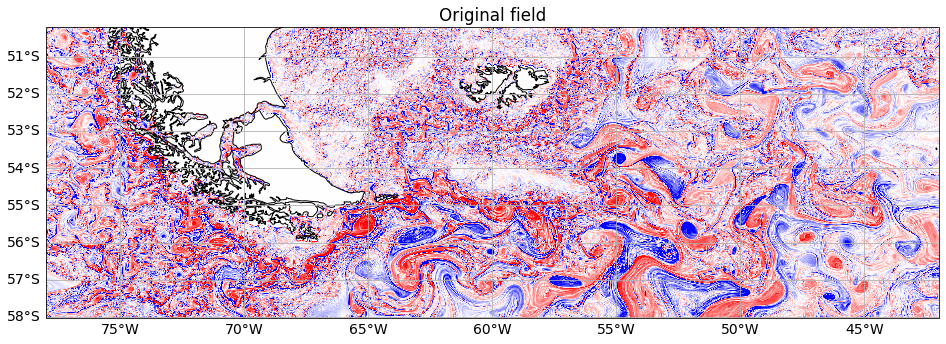

In [65]:
fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
rv = relvort3.isel()
p = rv.plot(vmin=-1e-4, vmax=1e-4, cmap='bwr')
ax.coastlines()
ax.set_extent([282, 318, -56.78, -50.2])
gl = ax.gridlines(draw_labels=True)
gl.right_labels = None
gl.top_labels = None
ax.set_aspect(1.5)
ax.set_title('Original field')
p.colorbar.remove()

plt.savefig('Original.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight',
        metadata=None)

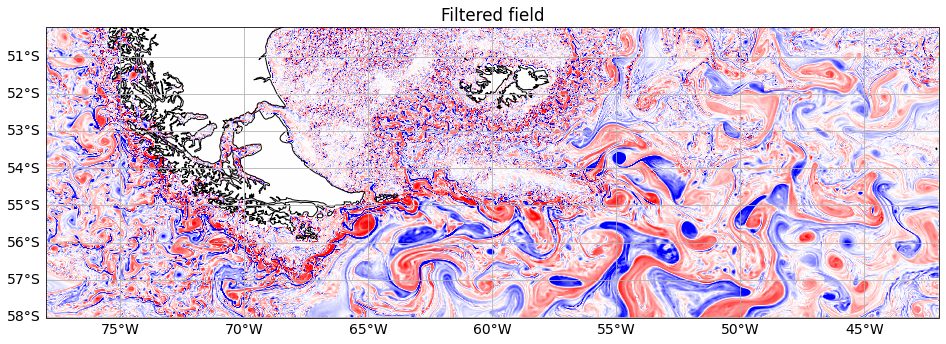

In [66]:
fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
rv = relvort3_filtered.isel()
p = rv.plot(vmin=-1e-4, vmax=1e-4, cmap='bwr')
ax.coastlines()
ax.set_extent([282, 318, -56.78, -50.2])
gl = ax.gridlines(draw_labels=True)
gl.right_labels = None
gl.top_labels = None
ax.set_aspect(1.5)
ax.set_title('Filtered field')
p.colorbar.remove()

plt.savefig('Filtered.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight',
        metadata=None)

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


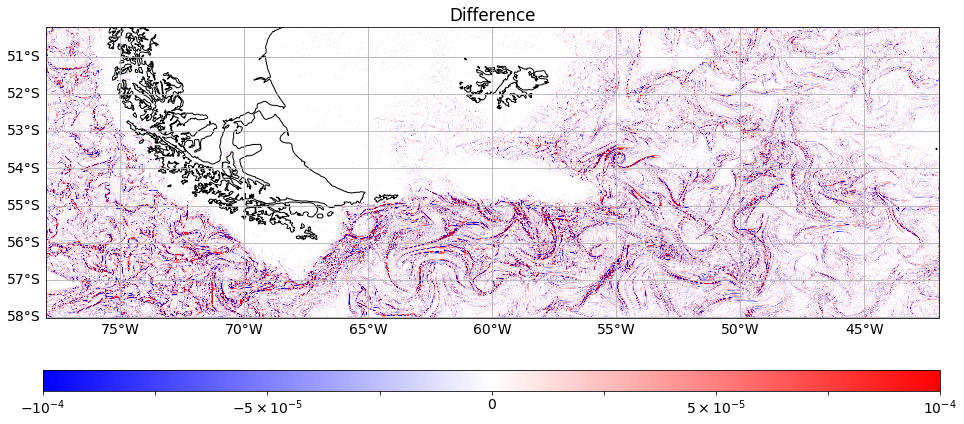

In [67]:


fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
rv = (relvort3 - relvort3_filtered).isel()
p = rv.plot(vmin=-1e-4, vmax=1e-4, cmap='bwr')
ax.coastlines()
ax.set_extent([282, 318, -56.78, -50.2])
gl = ax.gridlines(draw_labels=True)
gl.right_labels = None
gl.top_labels = None
ax.set_aspect(1.5)
ax.set_title('Difference')
p.colorbar.remove()
#fig.colorbar(p, orientation="horizontal", aspect=1)
cbax = fig.add_axes([0.123, 0.3, 0.623, 0.02])
cbar = fig.colorbar(p, orientation="horizontal", cax=cbax)
cbar.ax.set_xticklabels([r'$-10^{-4}$', '', r'$-5 \times 10^{-5}$', '', '0', '', r'$5 \times 10^{-5}$', '', r'$10^{-4}$'])

plt.savefig('Difference.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight',
        metadata=None)

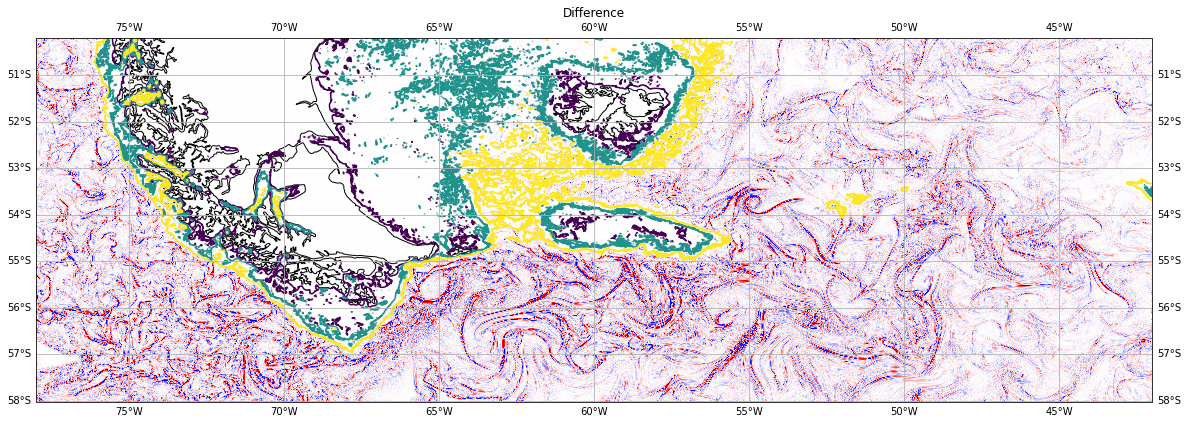

In [24]:

fig = plt.figure(figsize=(25, 25))
ax = plt.axes(projection=ccrs.PlateCarree())
rv = (relvort3 - relvort3_filtered).isel()
p = rv.plot(vmin=-1e-4, vmax=1e-4, cmap='bwr')
#xr.plot.contour(Ld, levels=[500, 1000, 2000])
ax.coastlines()
ax.set_extent([282, 318, -56.78, -50.2])
ax.gridlines(draw_labels=True)
ax.set_aspect(1.5)
ax.set_title('Difference')
p.colorbar.remove()